# Bitcoin Technical Analysis Linear Regression Model


Jericho Calago

In [32]:
#Imports here
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

## 1. Introduction

The goal of this research inquiry is to build a predictive model that will effectively predict 20 day profit/loss (abbreviated PnL), given conditions in the bitcoin market for new datasets. Our secondary research goal is to identify which technical analysis indicators for bitcoin trading contain the most predictive power, to help identify which ones are important on their own and which ones are important in tandem with other indicators.

Creating a model that yields reliable predictive insights into Bitcoin PnL can be a useful instrument for Bitcoin trading, helping traders predict bullish/bearish momentum and allowing them to time the market and make profits. Bitcoin traders would benefit from this model's insights greatly.

## 2. Dataset Discussion

In [2]:
df = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
start_rows = df.shape[0]
print(f"There are {start_rows} initial rows")

There are 4857377 initial rows


**Dataset Source**

The dataset was downloaded from the following link: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data.

According to the documentation, the data was grabbed from multiple global exchanges of Bitcoin, utilizing their APIs (online http addresses that allow for programmatic data extraction)

## 3. Dataset Cleaning

We start by dropping all rows that contain missing values (NaN)

In [4]:
nan_filter = df.dropna().copy()
print(f"Before: {df.shape[0]}, After: {nan_filter.shape[0]}")

Before: 4857377, After: 3613769


From here, we need to get rid of the days where there aren't enough available datapoints to construct a reliable daily price average. We can construct a column in the dataframe that uses python's datetime methods to convert the timestamp into the data, then get rid of the dates that have less than 10 hours of trading data (less than 600 1-minute intervals in the original dataset).

Leaving these dates out makes it more difficult to calculate moving averages due to having breaks in our data, but it ensures that the moving averages that are calculated are supported by enough datapoints to be considered as an accurate representation of the market on that particular day.

In [5]:
# create the Date column
nan_filter["Date"] = nan_filter["Timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).date())
nan_filter.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2011-12-31


In [6]:
# make a list of dates who have over 600 rows in the original dataset
date_counts = nan_filter["Date"].value_counts()
counts_greater_600 = date_counts[date_counts > 600]
counts_greater_600_li = counts_greater_600.index
counts_greater_600_li


Index([2020-11-01, 2017-11-05, 2019-11-03, 2019-07-04, 2018-01-07, 2018-04-18,
       2020-10-21, 2019-07-10, 2019-07-11, 2018-03-07,
       ...
       2016-08-27, 2016-07-29, 2013-09-08, 2013-08-04, 2016-10-08, 2013-06-29,
       2013-03-20, 2013-09-28, 2016-08-13, 2013-08-03],
      dtype='object', name='Date', length=2901)

In [7]:
# filter out all rows who come from a day with < 600 rows in the original dataset
day_filter = nan_filter[nan_filter["Date"].isin(counts_greater_600_li)]
print(f"NaN Filter: {nan_filter.shape[0]} -> Day Filter: {day_filter.shape[0]}")

NaN Filter: 3613769 -> Day Filter: 3554801


Now that all of our rows are part of a day that has over 600 datapoints in our dataset, we can aggregate the data so that we have one row for each day, rather than every minute. We can do this by taking the mean of each of the prices (open, high, low, and close), and summing up the total amount of traded bitcoin (Volume_(Currency)) per each day.

In [8]:
grouped_day_price_df = day_filter[["Date", "Open", "High", "Low", "Close"]].groupby("Date").mean().reset_index()
grouped_day_volume_df = day_filter[["Date", "Volume_(BTC)"]].groupby("Date").sum().reset_index()
grouped_day_df = grouped_day_price_df.merge(grouped_day_volume_df, how="left", on="Date")
grouped_day_df

,Date,Open,High,Low,Close,Volume_(BTC)
0,2013-03-06,45.138869,45.238359,45.065421,45.159959,17683.566854
1,2013-03-19,56.273216,56.304436,56.237927,56.271433,9111.546307
2,2013-03-20,63.089577,63.128274,63.059316,63.096938,8177.385871
3,2013-03-21,71.037541,71.091712,70.990353,71.045136,10180.621444
4,2013-03-23,63.128460,63.214857,63.045127,63.120000,13125.083718
...,...,...,...,...,...,...
2896,2021-03-26,53822.302397,53852.682217,53794.211452,53824.189611,4768.078044
2897,2021-03-27,55420.132804,55446.363867,55395.535839,55422.262112,2505.532832
2898,2021-03-28,55701.632734,55725.148399,55678.983545,55702.896538,1984.743044
2899,2021-03-29,57322.012224,57353.967227,57291.886359,57323.456067,5558.784133


From here we need to plan ahead for when we calculate our moving averages. The longest moving average we are looking to calcualte is a 26-day moving average, so from here we can separate our data into 3 categories:
- Calculable: The previous 25 days exist in the dataset, so we can calculate a 26 day EMA
- Relevant: Not a calculable point BUT used in a calculable point's 26 day EMA
- Dropable: Not part of a calculable point's 26 day EMA(Relevant) and also not calculable, can drop immediately.

In [9]:
# given a date object, generate a list of the 25 days before it
def generate_25_days_before(date):
    days_before = []
    for i in range(1, 26):
        day_i_before = date - datetime.timedelta(days = i)
        days_before.append(day_i_before)
    return days_before

# grab a list of all the days in our dataset
all_days = grouped_day_df["Date"].unique()

# Set to store all calculable days
days_with_calculable_sma = set()
# Set to store all days we must keep
relevant_days = set()

# Find all days where 20 day MSA is calculable
for date in all_days:
    day_range = generate_25_days_before(date)
    is_calculable = True

    for past_day in day_range:
        if past_day not in all_days:
            is_calculable = False
            break
    if is_calculable:
        days_with_calculable_sma.add(date)
        relevant_days.update(day_range)
final_filtered_df = grouped_day_df[grouped_day_df["Date"].isin(relevant_days) | grouped_day_df["Date"].isin(days_with_calculable_sma)]
print(f"Before: {len(all_days)}, After: {final_filtered_df.shape[0]}")

final_filtered_df["Is_Calculable"] = final_filtered_df["Date"].apply(lambda x : x in days_with_calculable_sma)
final_filtered_df.head()



Before: 2901, After: 2791


C:\Users\Jericho\AppData\Local\Temp\ipykernel_40204\1916411909.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_filtered_df["Is_Calculable"] = final_filtered_df["Date"].apply(lambda x : x in days_with_calculable_sma)


,Date,Open,High,Low,Close,Volume_(BTC),Is_Calculable
11,2013-04-07,157.013678,157.115734,156.925182,157.031821,8230.325687,False
12,2013-04-08,185.637813,185.821793,185.434712,185.664840,11954.241263,False
13,2013-04-09,216.701803,216.871010,216.497538,216.733490,11311.037062,False
14,2013-04-10,196.401490,197.200384,195.179733,196.201922,23704.782741,False
15,2013-04-11,107.131973,107.804018,106.197963,106.997931,40479.763285,False


To simplify our analysis, we will use OHLC average as our one metric for daily price, instead of comparing the open, high, low, and close individually.

In [10]:
# function to calculate the average of open, high, low, and close prices
def calculate_ohlc_avg(row):
    return (row["Open"] + row["High"] + row["Low"] + row["Close"]) / 4

# apply function and drop unecessary columns, reordering columns
final_filtered_df["OHLC_Avg"] = final_filtered_df.apply(calculate_ohlc_avg, axis=1)
final_filtered_df = final_filtered_df.drop(columns=["Open", "High", "Low", "Close"])[["Date", "OHLC_Avg", "Volume_(BTC)", "Is_Calculable"]]
final_filtered_df.head()

C:\Users\Jericho\AppData\Local\Temp\ipykernel_40204\1654294682.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_filtered_df["OHLC_Avg"] = final_filtered_df.apply(calculate_ohlc_avg, axis=1)


,Date,OHLC_Avg,Volume_(BTC),Is_Calculable
11,2013-04-07,157.021604,8230.325687,False
12,2013-04-08,185.639790,11954.241263,False
13,2013-04-09,216.700960,11311.037062,False
14,2013-04-10,196.245882,23704.782741,False
15,2013-04-11,107.032971,40479.763285,False


Lastly, we need to create a column for our response variable, which would be the profit or loss (abbreviated PnL) of bitcoin 20 days after the current day. We can do this by first creating a column that represents the day 20 days into the future, then this dataframe with one that has just price and date the price so we have a column for the price 20 days later, then finally creating the column for PnL by subtracting the current price from the future price.

In [11]:
# create column for day located 20 days into the future
final_filtered_df["future_day"] = final_filtered_df["Date"].apply(lambda x : x + datetime.timedelta(days=20))

# merge price df with final df for price 20 days into the future
date_to_price = final_filtered_df[["Date", "OHLC_Avg"]]
final_filtered_df = final_filtered_df.merge(right=date_to_price, left_on="future_day", right_on="Date", how="left")

# drop duplicated/unecessary columns after the merge and also drop all na values for which the merge doesn't exist
final_filtered_df = final_filtered_df.rename(columns={"OHLC_Avg_x": "OHLC_Avg", "OHLC_Avg_y" : "20_day_future_price", "Date_x" : "Date"}).drop(columns=["future_day", "Date_y"])

# calculate profit by subtracting current price from price 
final_filtered_df["20_day_pnl"] = final_filtered_df["20_day_future_price"] - final_filtered_df["OHLC_Avg"]
final_filtered_df = final_filtered_df.drop(columns=["20_day_future_price"])
final_filtered_df

,Date,OHLC_Avg,Volume_(BTC),Is_Calculable,20_day_pnl
0,2013-04-07,157.021604,8230.325687,False,-24.236394
1,2013-04-08,185.639790,11954.241263,False,-51.215362
2,2013-04-09,216.700960,11311.037062,False,-74.710248
3,2013-04-10,196.245882,23704.782741,False,-55.999624
4,2013-04-11,107.032971,40479.763285,False,17.584738
...,...,...,...,...,...
2786,2021-03-26,53823.346419,4768.078044,True,NaN
2787,2021-03-27,55421.073656,2505.532832,True,NaN
2788,2021-03-28,55702.165304,1984.743044,True,NaN
2789,2021-03-29,57322.830469,5558.784133,True,NaN


## 3.1. Indicator Construction

**(From a grading standpoint, there is NOTHING within this section, feel free to move on)**

Below is the code for creating the various technical indicators used to construct our linear regression models along with brief explanations. 

We will first start by constructing the relevant moving averages (20 day price SMA, (26 and 12) day price EMA, (9 and 12) day volume EMA), along with the 20 day moving standard deviation.

In [12]:

# calculate 20 day sma + std for Bollinger Band indicator
final_filtered_df['price_sma_20'] = final_filtered_df['OHLC_Avg'].rolling(window=20).mean()
final_filtered_df['price_std_20'] = final_filtered_df['OHLC_Avg'].rolling(window=20).std()

# calculate 12 and 26 day ema for MACD indicator
final_filtered_df["price_ema_26"] = final_filtered_df["OHLC_Avg"].ewm(span=26, adjust=False).mean()
final_filtered_df["price_ema_12"] = final_filtered_df["OHLC_Avg"].ewm(span=12, adjust=False).mean()

# calculate 9 and 12 day volume ema for Volume Oscillator indicator
final_filtered_df["volume_ema_26"] = final_filtered_df["Volume_(BTC)"].ewm(span=26, adjust=False).mean()
final_filtered_df["volume_ema_9"] = final_filtered_df["Volume_(BTC)"].ewm(span=9, adjust=False).mean()

final_filtered_df.head()

,Date,OHLC_Avg,Volume_(BTC),Is_Calculable,20_day_pnl,price_sma_20,price_std_20,price_ema_26,price_ema_12,volume_ema_26,volume_ema_9
0,2013-04-07,157.021604,8230.325687,False,-24.236394,NaN,NaN,157.021604,157.021604,8230.325687,8230.325687
1,2013-04-08,185.639790,11954.241263,False,-51.215362,NaN,NaN,159.141470,161.424402,8506.171286,8975.108803
2,2013-04-09,216.700960,11311.037062,False,-74.710248,NaN,NaN,163.405136,169.928488,8713.939121,9442.294454
3,2013-04-10,196.245882,23704.782741,False,-55.999624,NaN,NaN,165.837783,173.977318,9824.371982,12294.792112
4,2013-04-11,107.032971,40479.763285,False,17.584738,NaN,NaN,161.481871,163.678187,12095.141708,17931.786347


Now that we have our moving averages, we can drop all of the "relevant" but "not calculable" (rows used to calculate moving averages that do not have a valid moving average of its own) rows via the "Is_Calculable" column, along with the rows who's 20_day_pnl is NaN due to the future date not existing in our dataframe.

In [13]:
final_calculable_df = final_filtered_df[final_filtered_df["Is_Calculable"]].drop(columns="Is_Calculable").dropna()
final_calculable_df

,Date,OHLC_Avg,Volume_(BTC),20_day_pnl,price_sma_20,price_std_20,price_ema_26,price_ema_12,volume_ema_26,volume_ema_9
69,2013-09-13,127.764168,8857.668473,-13.547674,122.428944,5.552821,121.347949,123.405372,13130.006723,13435.470925
70,2013-09-14,125.427459,7803.368706,-3.968819,123.110792,4.986079,121.650135,123.716462,12735.440944,12309.050481
96,2013-10-11,126.830254,8452.102322,74.612180,123.583804,3.518166,123.522801,124.023970,12700.796527,12609.275633
97,2013-10-12,127.560075,6683.244369,75.343613,123.806971,3.625565,123.821859,124.567986,12255.051922,11424.069380
98,2013-10-13,130.472050,19817.544532,74.024860,124.176665,3.912923,124.314465,125.476303,12815.236560,13102.764411
...,...,...,...,...,...,...,...,...,...,...
2766,2021-03-06,48572.696888,2093.428764,5250.649531,50033.719052,3192.289728,47359.356101,48721.403266,7506.600323,5495.132521
2767,2021-03-07,50601.158137,3108.922009,4819.915518,50155.928922,3163.314556,47599.489585,49010.596323,7180.846374,5017.890418
2768,2021-03-08,51413.344187,5533.312775,4288.821117,50273.701798,3164.129614,47881.997333,49380.249840,7058.806848,5120.974890
2769,2021-03-09,54195.689473,5146.062955,3127.140996,50403.837326,3272.898266,48349.678233,50121.086707,6917.122115,5125.992503


Our first indicator is the Bollinger Band, which attempts to measure volatility within price levels by comparing the standard deviation over the past 20 days with the 20 day simple moving average of price levels. We will define our bollinger band with a width of 4x the 20 day standard deviation. You can read more about Bollinger Band indicators here: https://en.wikipedia.org/wiki/Bollinger_Bands. Below is a graph that chars the band on top of the OHLC average.

C:\Users\Jericho\AppData\Local\Temp\ipykernel_40204\3788329452.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bollinger["band_bot"] = df_bollinger.apply(calculate_band_bot, axis=1)
C:\Users\Jericho\AppData\Local\Temp\ipykernel_40204\3788329452.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bollinger["band_top"] = df_bollinger.apply(calculate_band_top, axis=1)


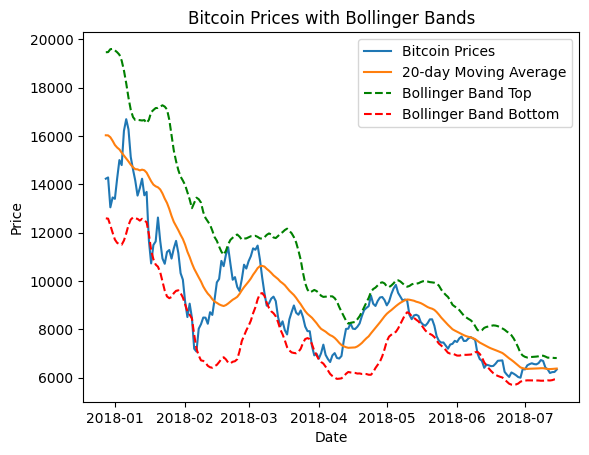

In [14]:
# functions to find the restrictions of the band + band with
def calculate_band_top(row):
    return row["price_sma_20"] + 2*row["price_std_20"]
def calculate_band_bot(row):
    return row["price_sma_20"] - 2*row["price_std_20"]

df_bollinger = final_calculable_df[["Date", "OHLC_Avg", "price_std_20", "price_sma_20"]]
df_bollinger["band_bot"] = df_bollinger.apply(calculate_band_bot, axis=1)
df_bollinger["band_top"] = df_bollinger.apply(calculate_band_top, axis=1)

def plot_bollinger_band(dataset, start = 0, end = -1):
    plt.clf()
    if end == -1:
        end = dataset.shape[0]
    
    dataset_subset = dataset.iloc[start:end]
    # Plot Bitcoin prices
    plt.plot(dataset_subset['Date'], dataset_subset['OHLC_Avg'], label='Bitcoin Prices')

    # Plot 20-day Moving Average
    plt.plot(dataset_subset['Date'], dataset_subset['price_sma_20'], label='20-day Moving Average')

    # Plot Bollinger Bands
    plt.plot(dataset_subset['Date'], dataset_subset['band_top'], label='Bollinger Band Top', linestyle='--', color='green')
    plt.plot(dataset_subset['Date'], dataset_subset['band_bot'], label='Bollinger Band Bottom', linestyle='--', color='red')


    # Add labels and legend
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Bitcoin Prices with Bollinger Bands')
    plt.legend()

plot_bollinger_band(df_bollinger[1300:1500])

We will have two main indicators for the band, the first will be the width of the band (4x the standard deviation), and the second will be the %b, which measures how close the current price is to the top (%b = 1) and bottom (%b = 0) of the band. 

In [15]:
# function to calculate the %b metric
def calculate_percent_b(row):
    return (row["OHLC_Avg"] - row["band_bot"]) / (row["band_width"])
# create columns for Bollinger Band indicators
df_bollinger["band_width"] = df_bollinger["price_std_20"].apply(lambda x : 4*x)
df_bollinger["percent_b"] = df_bollinger.apply(calculate_percent_b, axis=1)

# create final Bollinger Band dataframe
df_bollinger = df_bollinger[["Date", "band_width", "percent_b"]]
df_bollinger

C:\Users\Jericho\AppData\Local\Temp\ipykernel_40204\2421129533.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bollinger["band_width"] = df_bollinger["price_std_20"].apply(lambda x : 4*x)
C:\Users\Jericho\AppData\Local\Temp\ipykernel_40204\2421129533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bollinger["percent_b"] = df_bollinger.apply(calculate_percent_b, axis=1)


,Date,band_width,percent_b
69,2013-09-13,22.211284,0.740203
70,2013-09-14,19.944316,0.616157
96,2013-10-11,14.072663,0.730692
97,2013-10-12,14.502261,0.758794
98,2013-10-13,15.651693,0.902218
...,...,...,...
2766,2021-03-06,12769.158911,0.385582
2767,2021-03-07,12653.258225,0.535187
2768,2021-03-08,12656.518455,0.590044
2769,2021-03-09,13091.593065,0.789640


Our second indicator is the Moving Average Convergence Divergence (MACD), which attempts to identify changes in price momentum by comparing the difference in a long and short exponential moving average of price. We will use the most common MACD setup, which is the MACD(12, 26, 9) (short moving average of 12, long EMA of 26, and EMA of the MACD with a period of 9 days). You can read more about the MACD indicator here: https://en.wikipedia.org/wiki/MACD

In [16]:
df_macd = final_filtered_df[["Date", "price_ema_26", "price_ema_12", "Is_Calculable"]]
# construct the MACD line by taking the difference of the 12-day and 26-day exponential moving average
df_macd["macd_line"] = df_macd["price_ema_12"] - df_macd["price_ema_26"]
# construct the signal line by taking the 9 day exponential moving average of the MACD line
df_macd["macd_signal_line"] = df_macd["macd_line"].ewm(span=9, adjust=False).mean()
# construct the value that usually is plotted on a histogram to indentify signals utilizing the MACD
df_macd["macd_histo"] = df_macd["macd_line"] - df_macd["macd_signal_line"]
df_macd

C:\Users\Jericho\AppData\Local\Temp\ipykernel_40204\3192485432.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_macd["macd_line"] = df_macd["price_ema_12"] - df_macd["price_ema_26"]
C:\Users\Jericho\AppData\Local\Temp\ipykernel_40204\3192485432.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_macd["macd_signal_line"] = df_macd["macd_line"].ewm(span=9, adjust=False).mean()
C:\Users\Jericho\AppData\Local\Temp\ipykernel_40204\3192485432.py:7: SettingWithCopyWarning: 
A value is trying to be set on 

,Date,price_ema_26,price_ema_12,Is_Calculable,macd_line,macd_signal_line,macd_histo
0,2013-04-07,157.021604,157.021604,False,0.000000,0.000000,0.000000
1,2013-04-08,159.141470,161.424402,False,2.282932,0.456586,1.826346
2,2013-04-09,163.405136,169.928488,False,6.523352,1.669940,4.853413
3,2013-04-10,165.837783,173.977318,False,8.139534,2.963858,5.175676
4,2013-04-11,161.481871,163.678187,False,2.196316,2.810350,-0.614034
...,...,...,...,...,...,...,...
2786,2021-03-26,54017.712310,55195.356079,True,1177.643769,2042.547208,-864.903439
2787,2021-03-27,54121.665002,55230.081860,True,1108.416858,1855.721138,-747.304280
2788,2021-03-28,54238.739098,55302.710082,True,1063.970984,1697.371107,-633.400123
2789,2021-03-29,54467.190311,55613.497834,True,1146.307523,1587.158390,-440.850867


Via our formula, the MACD value is the difference between the 12 and 26 day exponential moving averages (positive = 12 day EMA is higher than the 26 day EMA and prices are rising). Therefore, if the MACD line is below the signal line, we expect bearish (down trending) momentum, as this means the current MACD value is below the 9 day expoential moving average, implying that prices are starting to swing downards. Conversely, if the MACD line is above the signal line, we expect bullish (upwards) momentum, as this means the current MACD value is above the 9 day exponential moving average.

We define this expected behavior in the dataframe below:

In [17]:
# define bearish and bullish MACD indicators
df_macd["MACD_Indicator"] = df_macd["macd_histo"].apply(lambda x : "Bearish" if x < 0 else "Bullish")
# remove "non calculable" rows
df_macd = df_macd[df_macd["Is_Calculable"]][["Date", "MACD_Indicator"]]
df_macd

C:\Users\Jericho\AppData\Local\Temp\ipykernel_40204\2660531871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_macd["MACD_Indicator"] = df_macd["macd_histo"].apply(lambda x : "Bearish" if x < 0 else "Bullish")


,Date,MACD_Indicator
25,2013-05-02,Bullish
26,2013-05-03,Bearish
27,2013-05-04,Bearish
28,2013-05-05,Bearish
29,2013-05-06,Bearish
...,...,...
2786,2021-03-26,Bearish
2787,2021-03-27,Bearish
2788,2021-03-28,Bearish
2789,2021-03-29,Bearish


The final indicator we will use is the Volume Oscillator, which attempts to identify changes in trading volume by comparing a short term volume ema with a long term volume ema. We will use a 26 day ema for long term and a 9 day volume ema for the short term. You can read more about volume oscillators here: https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/volume-oscillator.

In [18]:
# create dataframe to hold volume oscilator info
df_vol_osci = final_calculable_df[["Date", "volume_ema_9", "volume_ema_26"]]

# create volume oscillator column
df_vol_osci["volume_osci"] = df_vol_osci["volume_ema_9"] - df_vol_osci["volume_ema_26"]

# isolate volume oscillator column
df_vol_osci = df_vol_osci.drop(columns=["volume_ema_9", "volume_ema_26"])
df_vol_osci

C:\Users\Jericho\AppData\Local\Temp\ipykernel_40204\3808157806.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vol_osci["volume_osci"] = df_vol_osci["volume_ema_9"] - df_vol_osci["volume_ema_26"]


,Date,volume_osci
69,2013-09-13,305.464201
70,2013-09-14,-426.390463
96,2013-10-11,-91.520893
97,2013-10-12,-830.982542
98,2013-10-13,287.527851
...,...,...
2766,2021-03-06,-2011.467802
2767,2021-03-07,-2162.955955
2768,2021-03-08,-1937.831958
2769,2021-03-09,-1791.129612


Now that we've created dataframes for all of our indicators, we can combine these into one main dataframe to use for our analysis.

In [19]:
# merge all indicator dataframes into the original
final_df = final_calculable_df[["Date", "OHLC_Avg", "Volume_(BTC)", "20_day_pnl"]]
final_df = final_df.merge(right=df_bollinger, on="Date", how="left")
final_df = final_df.merge(right=df_macd, on="Date", how="left")
final_df = final_df.merge(right=df_vol_osci, on="Date", how="left")
final_df = final_df.drop(columns="Date")
final_df = pd.get_dummies(final_df, columns=["MACD_Indicator"], dtype=int).drop(columns="MACD_Indicator_Bullish")
final_df

,OHLC_Avg,Volume_(BTC),20_day_pnl,band_width,percent_b,volume_osci,MACD_Indicator_Bearish
0,127.764168,8857.668473,-13.547674,22.211284,0.740203,305.464201,0
1,125.427459,7803.368706,-3.968819,19.944316,0.616157,-426.390463,0
2,126.830254,8452.102322,74.612180,14.072663,0.730692,-91.520893,0
3,127.560075,6683.244369,75.343613,14.502261,0.758794,-830.982542,0
4,130.472050,19817.544532,74.024860,15.651693,0.902218,287.527851,0
...,...,...,...,...,...,...,...
2464,48572.696888,2093.428764,5250.649531,12769.158911,0.385582,-2011.467802,1
2465,50601.158137,3108.922009,4819.915518,12653.258225,0.535187,-2162.955955,1
2466,51413.344187,5533.312775,4288.821117,12656.518455,0.590044,-1937.831958,1
2467,54195.689473,5146.062955,3127.140996,13091.593065,0.789640,-1791.129612,1


## 4. Preliminary Analysis

We will start off by analyzing if any of our numerical explanatory variables display signs of a linear correlation:

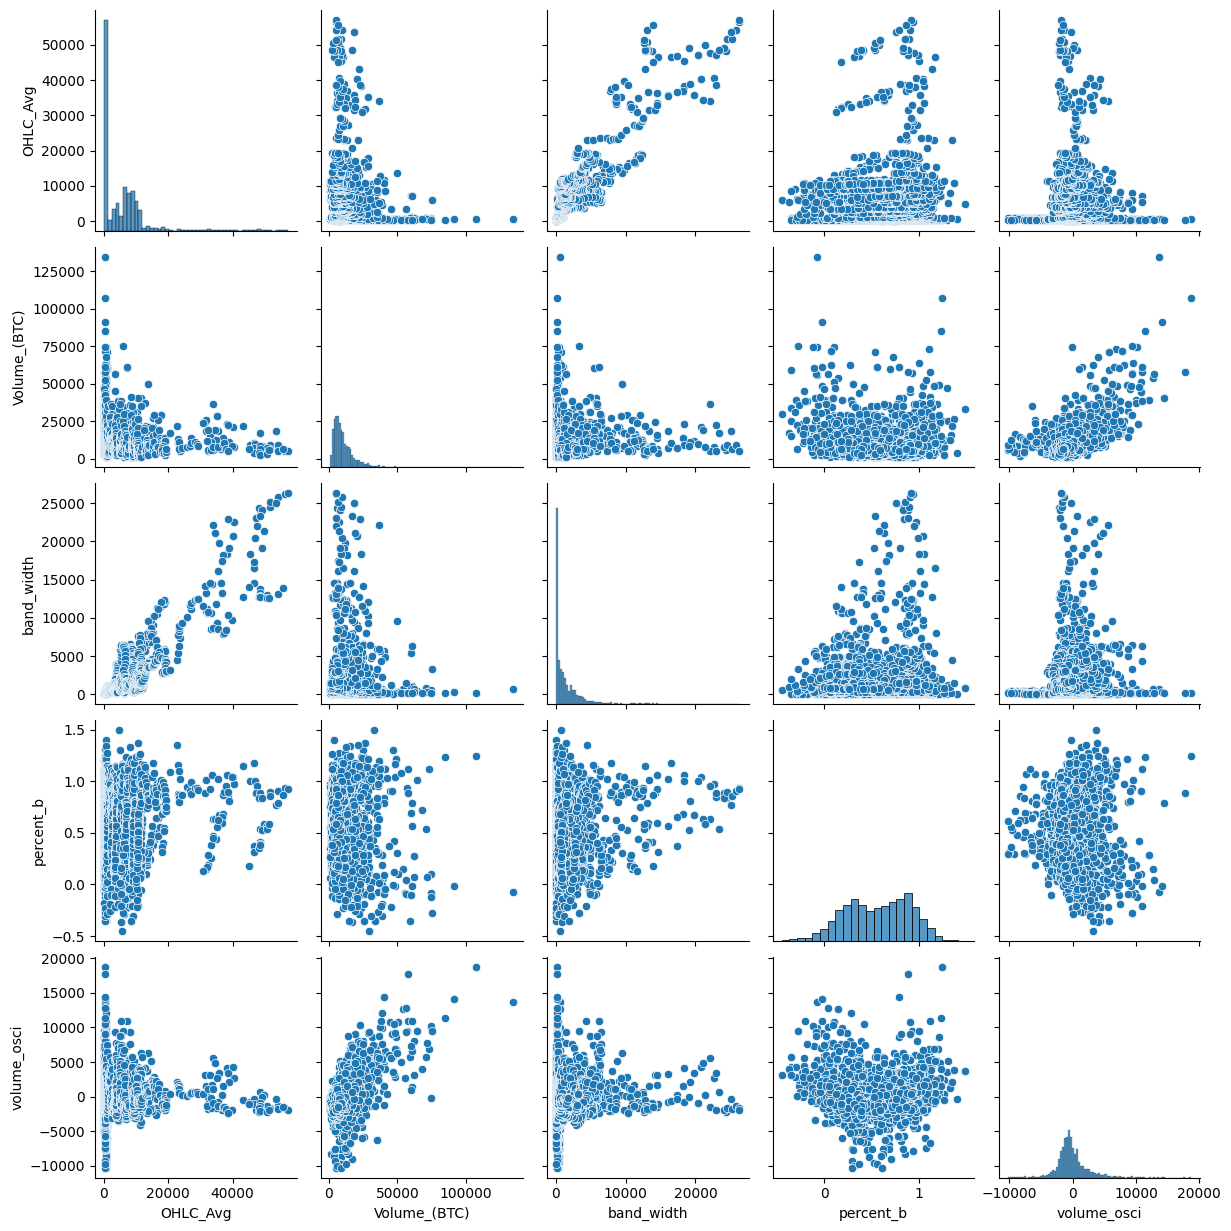

In [20]:
numerical_variables = ["OHLC_Avg", "Volume_(BTC)", "band_width", "percent_b", "volume_osci"]
df_numerical = final_df[numerical_variables]
sns.pairplot(df_numerical)

In [21]:
df_numerical.corr()

,OHLC_Avg,Volume_(BTC),band_width,percent_b,volume_osci
OHLC_Avg,1.000000,-0.092916,0.897055,0.091922,-0.009507
Volume_(BTC),-0.092916,1.000000,0.037475,-0.027465,0.618198
band_width,0.897055,0.037475,1.000000,0.076554,0.079090
percent_b,0.091922,-0.027465,0.076554,1.000000,-0.001974
volume_osci,-0.009507,0.618198,0.079090,-0.001974,1.000000


Via the above pairplot, we can only identify one pair of numerical variables that seems to exhibit collinearity: band_width and OHLC_Avg. Looking at the correlation coefficients confirms this, as band_width and OHLC_Avg have a correlation coefficient of 0.897, which implies they have a noticeable linear relationship. This information may be useful for our feature selection algorithms later on in the report.


We will now train a standard linear regression model using all of the explanatory variables within our dataset, and plot a fitted values vs residuals plot to determine the effectiveness of a *linear* regression model over other types of regression. We can also take a look at the model's R^2 value to see how well it predicts 20 day PnL based on existing values in the dataset.

In [22]:
standard_obj = LinearRegression()
features = final_df.drop(columns=["20_day_pnl"])
target = final_df["20_day_pnl"]
full_model = standard_obj.fit(features, target)

pred_target = full_model.predict(features)
r2_score(target, pred_target)


0.2210611806699525

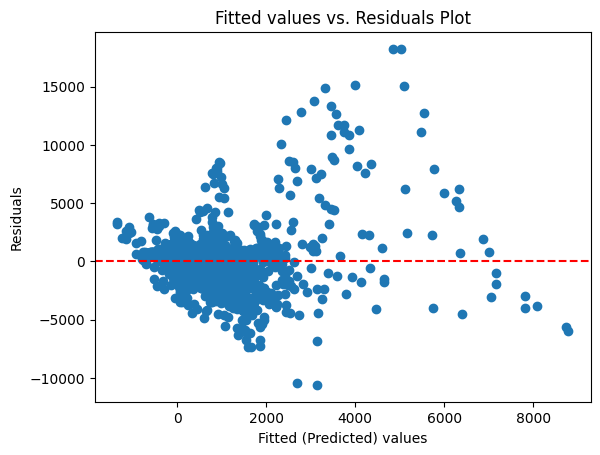

In [23]:
residuals = target - pred_target
plt.scatter(pred_target, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted (Predicted) values')
plt.ylabel('Residuals')
plt.title('Fitted values vs. Residuals Plot')
plt.show()

Based on the Fitted Values vs Residuals Plot, our model meets the linearity principle, as at different levels for predicted values, the model underestimates and overestimates the true value at relatively similar frequencies. We therefore have no reason to transform any variables to change the output of our model, and should focus on including new/excluding current features to maximize the model $R^2$ value, as 0.22 is quite low.

### Interaction Terms:
We will explore the need to add interaction terms by indentifying how our categorical variable (MACD_Indicator) impacts the relationship between our numerical explanatory variables and our response variable (20 day pnl). We'll first start by regathering the MACD_Indicator column then plotting scatterplots for each numerical variable, controlling for the value found in the MACD_Indicator column.

In [24]:
# recreate MACD_Indicator column from our Bullish and Bearish columns
df_interaction = final_df.copy()
df_interaction["MACD_Indicator"] = df_interaction["MACD_Indicator_Bearish"].apply(lambda x : "Bearish" if x else "Bullish")
df_interaction = df_interaction.drop(columns=["MACD_Indicator_Bearish"])
df_interaction

,OHLC_Avg,Volume_(BTC),20_day_pnl,band_width,percent_b,volume_osci,MACD_Indicator
0,127.764168,8857.668473,-13.547674,22.211284,0.740203,305.464201,Bullish
1,125.427459,7803.368706,-3.968819,19.944316,0.616157,-426.390463,Bullish
2,126.830254,8452.102322,74.612180,14.072663,0.730692,-91.520893,Bullish
3,127.560075,6683.244369,75.343613,14.502261,0.758794,-830.982542,Bullish
4,130.472050,19817.544532,74.024860,15.651693,0.902218,287.527851,Bullish
...,...,...,...,...,...,...,...
2464,48572.696888,2093.428764,5250.649531,12769.158911,0.385582,-2011.467802,Bearish
2465,50601.158137,3108.922009,4819.915518,12653.258225,0.535187,-2162.955955,Bearish
2466,51413.344187,5533.312775,4288.821117,12656.518455,0.590044,-1937.831958,Bearish
2467,54195.689473,5146.062955,3127.140996,13091.593065,0.789640,-1791.129612,Bearish


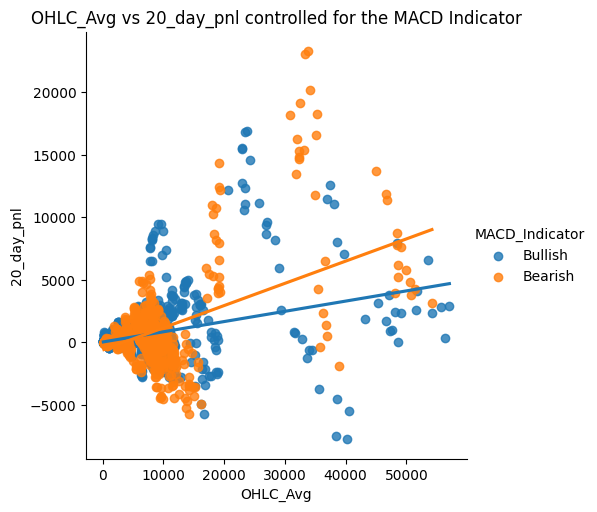

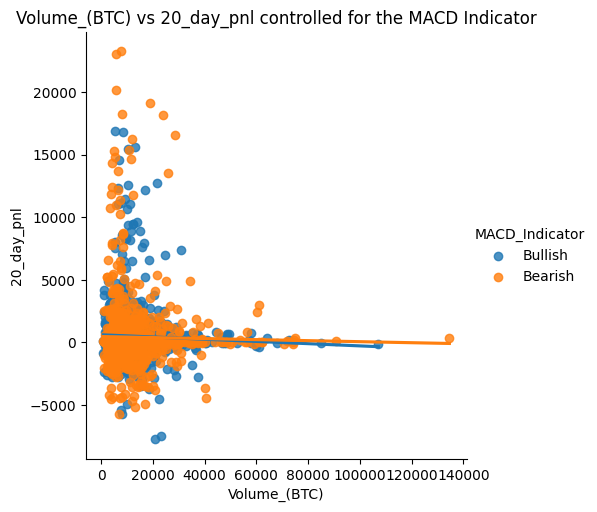

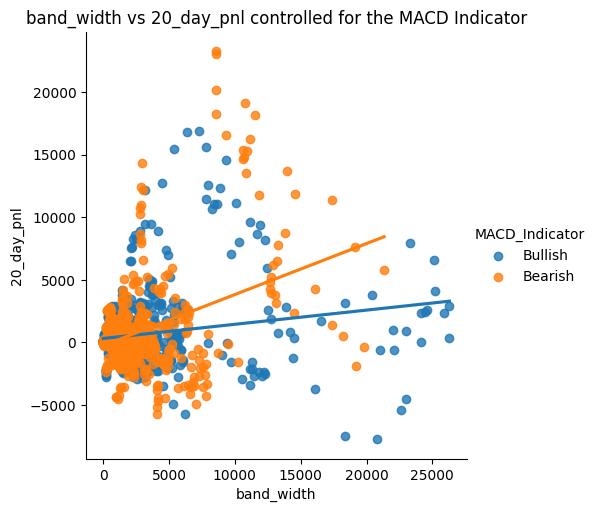

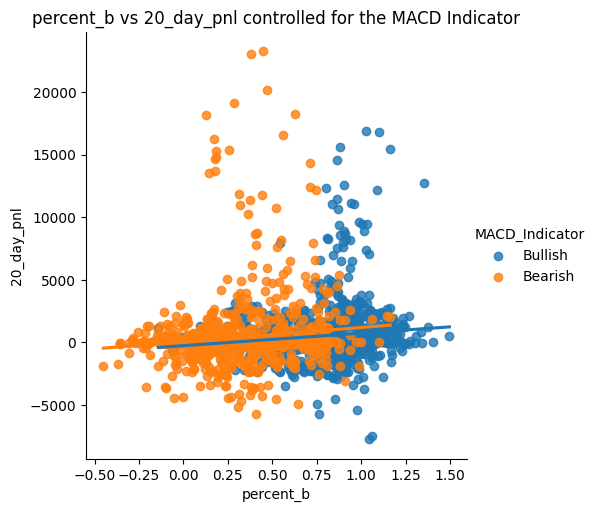

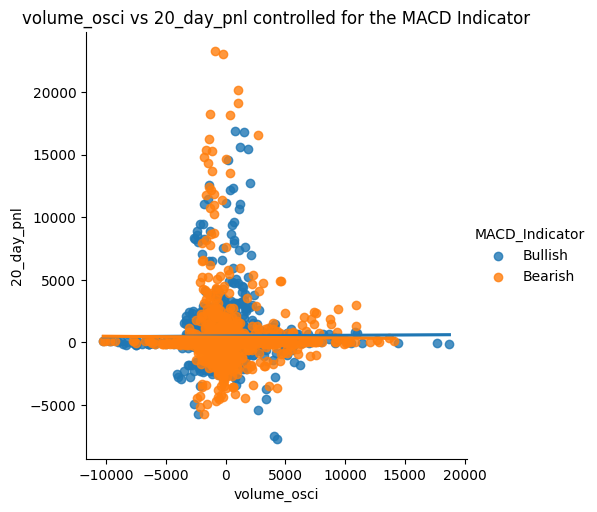

In [25]:
# plot scatterplots for each numerical variable vs the 20 day PnL controlling for MACD Indicator status
for var in numerical_variables:
    sns.lmplot(x=var, y="20_day_pnl", hue='MACD_Indicator', ci=False, data=df_interaction)
    plt.title(f"{var} vs 20_day_pnl controlled for the MACD Indicator")
    plt.show()

As seen in the scatterplots above, there seems to be an interaction between a numerical variable and the MACD indicator for two different numerical variables: band_width and OHLC_Avg. We can create interaction terms for these two interactions to see if it improves our model's R^2.

In [43]:
interaction_features = final_df.copy()
interaction_features['ohlc*macd'] = interaction_features['OHLC_Avg']*interaction_features['MACD_Indicator_Bearish']
interaction_features["bandWidth*macd"] = interaction_features['band_width']*interaction_features['MACD_Indicator_Bearish']
interaction_features

,OHLC_Avg,Volume_(BTC),20_day_pnl,band_width,percent_b,volume_osci,MACD_Indicator_Bearish,ohlc*macd,bandWidth*macd
0,127.764168,8857.668473,-13.547674,22.211284,0.740203,305.464201,0,0.000000,0.000000
1,125.427459,7803.368706,-3.968819,19.944316,0.616157,-426.390463,0,0.000000,0.000000
2,126.830254,8452.102322,74.612180,14.072663,0.730692,-91.520893,0,0.000000,0.000000
3,127.560075,6683.244369,75.343613,14.502261,0.758794,-830.982542,0,0.000000,0.000000
4,130.472050,19817.544532,74.024860,15.651693,0.902218,287.527851,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2464,48572.696888,2093.428764,5250.649531,12769.158911,0.385582,-2011.467802,1,48572.696888,12769.158911
2465,50601.158137,3108.922009,4819.915518,12653.258225,0.535187,-2162.955955,1,50601.158137,12653.258225
2466,51413.344187,5533.312775,4288.821117,12656.518455,0.590044,-1937.831958,1,51413.344187,12656.518455
2467,54195.689473,5146.062955,3127.140996,13091.593065,0.789640,-1791.129612,1,54195.689473,13091.593065


We can then test another full model (this time with interaction terms) to see whether this reduces our overall $R^2$

In [46]:
interaction_features_train = interaction_features.drop(columns="20_day_pnl")
full_interactions_model = standard_obj.fit(interaction_features_train, target)

pred_target = full_interactions_model.predict(interaction_features_train)
r2_score(target, pred_target)


0.23559407936502919

## 5. Predictive Models

We will start off by creating a train-test split of the given dataset, which should allow us to more accurately evaluate how good our model is at predicting 20 day PnL for new situations. Additionally, since we want our slopes to be interpretable in terms of how important an explanatory variable is when predicting the response variable, we will z-score scale both the training and the test data to gain better understanding on this metric (variable importance relative to other variables).

In [47]:
df_train, df_test = train_test_split(interaction_features, test_size=0.2)
print(f"{df_test.shape[0] / interaction_features.shape[0]}")

0.20008100445524504


In [56]:
scaler_obj = StandardScaler()
# creating features matrix for both test and train
x_train = df_train.drop(columns="20_day_pnl")
x_test = df_test.drop(columns="20_day_pnl")

# scaling both train and test dataset
scaled_x_vals_train = scaler_obj.fit_transform(x_train)
scaled_x_vals_test = scaler_obj.fit_transform(x_test)

# copying into new dataframes
scaled_x_train = pd.DataFrame(scaled_x_vals_train, columns=x_train.columns)
scaled_x_test = pd.DataFrame(scaled_x_vals_test, columns=x_test.columns)

# verifying the standard deviations 
print(scaled_x_test.std())
print(scaled_x_train.std())



OHLC_Avg                  1.001014
Volume_(BTC)              1.001014
band_width                1.001014
percent_b                 1.001014
volume_osci               1.001014
MACD_Indicator_Bearish    1.001014
ohlc*macd                 1.001014
bandWidth*macd            1.001014
dtype: float64
OHLC_Avg                  1.000253
Volume_(BTC)              1.000253
band_width                1.000253
percent_b                 1.000253
volume_osci               1.000253
MACD_Indicator_Bearish    1.000253
ohlc*macd                 1.000253
bandWidth*macd            1.000253
dtype: float64


## 5.2 Regularized Linear Regression Full Model

Recall that the full linear regression model fitted earlier contained an $R^2$ of 0.22, we will see how this changes now that we have train-test split the dataset.

In [62]:
#remove interaction terms columns
scaled_x_non_interaction_train = scaled_x_train.drop(columns=["ohlc*macd", "bandWidth*macd"])
scaled_x_non_interaction_test =  scaled_x_test.drop(columns=["ohlc*macd", "bandWidth*macd"])

# create test and train target
y_test = df_test["20_day_pnl"]
y_train = df_train["20_day_pnl"]

# using standard_obj (LinearRegression object) from earlier
full_scaled_model = standard_obj.fit(scaled_x_non_interaction_train, y_train)

# using model to predict 20 day PnL on test and train
test_pred_ = full_scaled_model.predict(scaled_x_non_interaction_test)
train_pred = full_scaled_model.predict(scaled_x_non_interaction_train)

# printing results
print(f"Test R^2: {r2_score(y_test, test_pred_)}")
print(f"Training R^2: {r2_score(y_train, train_pred)}")

Test R^2: 0.22202119601993597
Training R^2: 0.22291243640391545


,OHLC_Avg,Volume_(BTC),band_width,percent_b,volume_osci,MACD_Indicator_Bearish
0,0.412515,-0.064506,0.904917,-0.063143,-1.004565,-0.929597
1,-0.659079,0.077045,-0.537826,-0.386934,-1.039451,1.075735
2,-0.585948,-0.320160,-0.495772,1.424671,-0.528760,-0.929597
3,0.403052,1.563811,0.192554,-1.458975,0.432989,1.075735
4,0.373173,-0.958318,-0.384958,0.062863,-0.517190,-0.929597
...,...,...,...,...,...,...
489,4.529275,-0.497634,3.740104,-1.083473,-0.446307,1.075735
490,0.557246,0.532330,0.812090,1.074549,-0.866391,-0.929597
491,-0.310801,-0.696802,-0.440100,-1.167384,-0.430086,1.075735
492,-0.678959,0.761176,-0.517123,0.878818,0.267086,-0.929597


Both the  test $R^2$ and training $R^2$ of our scaled model are slightly higher than the overall $R^2$ of our overall full model without interaction terms (0.221 vs 0.222), but the difference is so small that it cannot be stated as a significant difference.

## 5.2 Regularized Linear Regression Full Model

Recall that the full linear regression model with interaction terms fitted earlier contained an $R^2$ of 0.23, we will see whether scaling our variables leads to a larger $R^2$ value.

In [61]:
# using standard_obj (LinearRegression object) from earlier
full_scaled_model = standard_obj.fit(scaled_x_train, y_train)


# using model to predict 20 day PnL on test and train
test_pred_ = full_scaled_model.predict(scaled_x_test)
train_pred = full_scaled_model.predict(scaled_x_train)

# printing results
print(f"Test R^2: {r2_score(y_test, test_pred_)}")
print(f"Training R^2: {r2_score(y_train, train_pred)}")

Test R^2: 0.22271965994332543
Training R^2: 0.2407954468357265


,OHLC_Avg,Volume_(BTC),band_width,percent_b,volume_osci,MACD_Indicator_Bearish,ohlc*macd,bandWidth*macd
0,0.412515,-0.064506,0.904917,-0.063143,-1.004565,-0.929597,-0.415621,-0.371808
1,-0.659079,0.077045,-0.537826,-0.386934,-1.039451,1.075735,-0.361088,-0.353084
2,-0.585948,-0.320160,-0.495772,1.424671,-0.528760,-0.929597,-0.415621,-0.371808
3,0.403052,1.563811,0.192554,-1.458975,0.432989,1.075735,0.980428,0.726652
4,0.373173,-0.958318,-0.384958,0.062863,-0.517190,-0.929597,-0.415621,-0.371808
...,...,...,...,...,...,...,...,...
489,4.529275,-0.497634,3.740104,-1.083473,-0.446307,1.075735,6.192022,5.971074
490,0.557246,0.532330,0.812090,1.074549,-0.866391,-0.929597,-0.415621,-0.371808
491,-0.310801,-0.696802,-0.440100,-1.167384,-0.430086,1.075735,0.078802,-0.208613
492,-0.678959,0.761176,-0.517123,0.878818,0.267086,-0.929597,-0.415621,-0.371808


The test $R^2$ of our scaled model is lower than the overall $R^2$ of the non-scaled model, but the training $R^2$ is higher. This very well could be due to the fact that the non-scaled model was being evaluated on the whole dataset, while the train and test predictions are only looking at a portion of the dataset. Either way, the difference is not significant enough to claim one is better than the other, so we will use the scaled model as a baseline as it has the added benefit of slope interpretability.

## 5.3 Feature Selection

Due to the overwhelming amount of datapoints and metrics provided, it is possible that the model is currently being overfit. We will utilize the altered regression function provided by LASSO regression for its error term containing a function of the sums of the slopes to identify slopes that do not bring a sufficient amount of predictive power to the model.

After computing many models, the identified range for lambda values that maximize the $R^2$ on the test dataset lies between 9 and 12. To correctly show this and show that this really is larger than lower lambdas of say, 0.05, we will test $\lambda$ values from 0 to 13, incrementing by 0.01 for each new model.

In [85]:
MAX_ITER = 1000
rows = []
for i in range(13001):
    lambda_ = 0 + 0.001 * i

    lasso_model = Lasso(alpha=lambda_, max_iter=MAX_ITER).fit(scaled_x_train, y_train)
    lasso_model_pred_y = lasso_model.predict(scaled_x_test)
    r2_val = r2_score(y_test, lasso_model_pred_y)

    rows.append([lambda_, r2_val])

lasso_r2_vals = pd.DataFrame(rows, columns=["lambda", "test_R^2"])
lasso_r2_vals.head()
    

C:\Users\Jericho\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1351: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\Jericho\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Jericho\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.239e+09, tolerance: 1.117e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

,lambda,test_R^2
0,0.000,0.22272
1,0.001,0.22272
2,0.002,0.22272
3,0.003,0.22272
4,0.004,0.22272


Now that we have trained all of the models, we can plot the test $R^2$ values for different values of lambda to see the relationship.

Text(0.5, 1.0, 'Test R^2 vs Lambda Values for Lasso Regression Models')

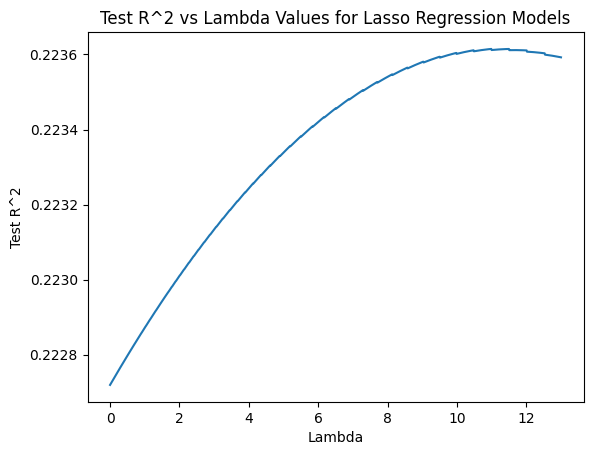

In [83]:
plt.plot(lasso_r2_vals["lambda"].values, lasso_r2_vals["test_R^2"].values)
plt.ylabel("Test R^2")
plt.xlabel("Lambda")
plt.title("Test R^2 vs Lambda Values for Lasso Regression Models")

By sorting the dataframe we made with all lambdas and test $R^2$, we can find the best model in terms of test $R^2$

In [84]:
lasso_r2_vals.sort_values(by="test_R^2", ascending=False)

,lambda,test_R^2
1099,10.99,0.223615
1098,10.98,0.223615
1150,11.50,0.223615
1149,11.49,0.223615
1097,10.97,0.223615
...,...,...
4,0.04,0.222726
3,0.03,0.222724
2,0.02,0.222723
1,0.01,0.222721


In [89]:
# train the best Lasso model in terms of test R^2
BEST_LAMBDA = 10.991
best_lasso_model = Lasso(alpha=BEST_LAMBDA, max_iter=MAX_ITER).fit(scaled_x_train, y_train)
best_lasso_model_pred_y = lasso_model.predict(scaled_x_test)
r2_val = r2_score(y_test, best_lasso_model_pred_y)
print(f"Best r2_val: {r2_val}")
print(f"Intercept: {best_lasso_model.intercept_}")
# extract all slopes and put into dataframe for easier viewing
rows = []
coef = best_lasso_model.coef_
names = best_lasso_model.feature_names_in_
for i in range(len(best_lasso_model.coef_)):
    rows.append([coef[i], names[i]])
lasso_model_slope_df = pd.DataFrame(rows, columns=["Variable", "Slope_Lasso"])
lasso_model_slope_df



Best r2_val: 0.22359234432930408
Intercept: 464.96236023763055


,Variable,Slope_Lasso
0,1571.886934,OHLC_Avg
1,161.777021,Volume_(BTC)
2,-962.297826,band_width
3,173.468099,percent_b
4,7.763850,volume_osci
5,-136.599361,MACD_Indicator_Bearish
6,365.144542,ohlc*macd
7,112.505775,bandWidth*macd


As we can see, the best $R^2$ value is only 0.0008 away from the worst $R^2$ value, and additionally, none of the slopes were zeroed out. We will discuss what this means in part 6.

## 6. Best Model Discussion

The equation for our "best" LASSO model is as follows: 

\begin{align*}
    \hat{20\_day\_PnL} = & 464.96236023763055 \\
    & + 1571.886934(\text{OHLC\_Avg}) \\
    & + 161.777021(\text{Volume\_(BTC)}) \\
    & - 962.297826(\text{band\_width}) \\
    & + 173.468099(\text{percent\_b}) \\
    & + 7.763850(\text{volume\_osci}) \\   
    & - 136.599361(\text{MACD\_Indicator\_Bearish}) \\   
    & + 365.144542(\text{ohlc*macd}) \\  
    & + 112.505775(\text{bandWidth*macd})
\end{align*}

While the model does meet the linearity assumption, the test $R^2$ of 0.223 is not accurate, and the model does not fully represent the market conditions or 20 day PnL (is a pretty poor fit).

This model does provide insight into which variables and indicators might be more effective in price prediction than others, as we z-score scaled each of our explanatory variables. In particular, the OHLC average seems to be the most important, which makes sense as higher price levels means even smaller percentage fluctuations in price will still lead to larger raw profit or loss. Next comes band width, which also makes sense as the width measures volatility, or how rapidly the price has fluctuated in the past 20 days. From here the slope magnitudes become much smaller (and the next nearest term is an interaction term with OHLC), so one possible interpretation is that these indicators don't add nearly as much predictive power as pure price and 20 day volatility.

However, our model did not 0 out any slopes despite the LASSO error term, so our model isn't overfitting, and can even take more variables to potentially increase the test $R^2$ this makes sense as we only scratched the surface in terms of the technical analysis indicators we chose to include within our model, so it is possible that a better combination of features will yield a much higher $R^2$.

We did not have any issues with multicollinearity as seen earlier on in the analysis.

## 7. Conclusion

It is important to keep in mind that a test $R^2$ of 0.223 is not very accurate, and this model should not be used to try and predict real world conditions/support decisions for trading with real money. However, the lack of 0'd out slopes with such a high lambda value indicates that the model wasn't overfitting, and in fact, we could potentially add more indicators to try and see if these indicators can increase our model's $R^2$. A more complete analysis would test a much larger number of indicators and perform a much deeper dive into feature selection to truly maximize the possible test $R^2$ value.

Future work could go based off of this idea, testing even more technical analysis indicators in an attempt to maximize the test $R^2$, and ultimately only after we test a majority of the models can we make any claims about the validity of technical analysis as an overall practice.